In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train','val']}

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [5]:
def imshow(inp, title):
  inp = inp.numpy().transpose((1, 2, 0))
  inp = std*inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  plt.title(title)
  plt.show()

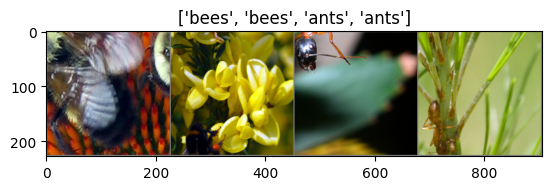

In [6]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model






In [8]:
# Finetuning ConvNet

# Loading a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features

# Size of each output sample set to 2.

# Can be generalized to nn.Linear(num_ftrs, len(class_names))

model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observing that all parameters are being optimized

optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR: Decays (hence altering) the learning rate of each parameter group by gamma every step_size epochs

# Here we decay LR by a factor of 0.1 for every 7 epochs

# LR scheduler is to be applied after optimizer updating

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.0MB/s]


Epoch 0/24
----------
train Loss: 0.7022 Acc: 0.5615
val Loss: 0.4412 Acc: 0.8589

Epoch 1/24
----------
train Loss: 0.5617 Acc: 0.7254
val Loss: 0.3355 Acc: 0.8896

Epoch 2/24
----------
train Loss: 0.4422 Acc: 0.8115
val Loss: 0.2865 Acc: 0.8957

Epoch 3/24
----------
train Loss: 0.4247 Acc: 0.7951
val Loss: 0.2447 Acc: 0.9080

Epoch 4/24
----------
train Loss: 0.4022 Acc: 0.8361
val Loss: 0.2222 Acc: 0.9325

Epoch 5/24
----------
train Loss: 0.4294 Acc: 0.7951
val Loss: 0.2265 Acc: 0.9387

Epoch 6/24
----------
train Loss: 0.3828 Acc: 0.8320
val Loss: 0.1902 Acc: 0.9387

Epoch 7/24
----------
train Loss: 0.3764 Acc: 0.8443
val Loss: 0.2159 Acc: 0.9264

Epoch 8/24
----------
train Loss: 0.3577 Acc: 0.8566
val Loss: 0.2068 Acc: 0.9264

Epoch 9/24
----------
train Loss: 0.3337 Acc: 0.8648
val Loss: 0.1997 Acc: 0.9387

Epoch 10/24
----------
train Loss: 0.3287 Acc: 0.8566
val Loss: 0.1867 Acc: 0.9325

Epoch 11/24
----------
train Loss: 0.3352 Acc: 0.8607
val Loss: 0.2058 Acc: 0.9325

Ep

In [9]:
# ConvNet as fixed feature extractor

model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():

  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layers are being optimized as opposed to before

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum =0.9)

# Decaying LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size =7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6223 Acc: 0.6352
val Loss: 0.2779 Acc: 0.9141

Epoch 1/24
----------
train Loss: 0.5167 Acc: 0.7582
val Loss: 0.2418 Acc: 0.9202

Epoch 2/24
----------
train Loss: 0.5488 Acc: 0.7213
val Loss: 0.2087 Acc: 0.9325

Epoch 3/24
----------
train Loss: 0.3695 Acc: 0.8197
val Loss: 0.2000 Acc: 0.9448

Epoch 4/24
----------
train Loss: 0.6487 Acc: 0.7582
val Loss: 0.2177 Acc: 0.9387

Epoch 5/24
----------
train Loss: 0.5154 Acc: 0.7992
val Loss: 0.2701 Acc: 0.9202

Epoch 6/24
----------
train Loss: 0.5359 Acc: 0.7582
val Loss: 0.2187 Acc: 0.9448

Epoch 7/24
----------
train Loss: 0.3444 Acc: 0.8689
val Loss: 0.2316 Acc: 0.9325

Epoch 8/24
----------
train Loss: 0.3747 Acc: 0.8320
val Loss: 0.2059 Acc: 0.9387

Epoch 9/24
----------
train Loss: 0.3918 Acc: 0.8402
val Loss: 0.1987 Acc: 0.9571

Epoch 10/24
----------
train Loss: 0.2561 Acc: 0.8934
val Loss: 0.2126 Acc: 0.9571

Epoch 11/24
----------
train Loss: 0.3793 Acc: 0.8361
val Loss: 0.2587 Acc: 0.9264

Ep